In [57]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mhm_drought_funcs as mdf
import seaborn as sns

#Segoe UI font
plt.rcParams['font.family'] = 'Segoe UI'

### Read SMI files

In [58]:
src_dir = r'W:\VUB\_main_research\mHM\mhm_outputs\mHM_EOBS\SMI_outputs'
smi_EOBS_masked = xr.open_dataset(os.path.join(src_dir, 'SMI.nc'), engine='netcdf4')
drought_ADM = pd.read_csv(os.path.join(src_dir, 'results_ADM.txt'), index_col=0, sep="\s+")

#### Major droughts

Index the drought events from the results_ADM by month

In [59]:
base_date = datetime(1970, 1, 31) # simulation starts from 1970-01-01, which is mStart=1, so we use 1969-12-31 as the base date

drought_ADM = mdf.assign_date_ADM(drought_ADM, base_date)

#### Lollipop plot of Drought Events 

In [60]:
def ADM_lolliplot_TDM(drought_ADM, top_n_events):
    """
    Create a lollipop plot for drought events with TDM as y-axis and marker sizes proportional to TDM.
    
    Parameters:
    - drought_ADM: DataFrame containing drought event data with 'start_month', 'end_month', and 'TDM' columns.
    - top_n_events: Number of top drought events to highlight and label.
    
    Returns:
    - None: Displays the plot.
    """
    top_TDM = drought_ADM.nlargest(top_n_events, 'TDM')

    fig, ax = plt.subplots(figsize=(27, 11), dpi=210)
    sns.set_style("whitegrid")

    # Stems for all events representing TDM
    for _, row in drought_ADM.iterrows():
        ax.plot([row['start_month'], row['start_month']], [0, row['TDM']],
                color='gray', linestyle='-', linewidth=0.2)

    # Calculate marker sizes proportional to TDM for all events
    marker_size_all = drought_ADM['TDM'] * 0.5  # adjust scaling factor as needed

    # Hollow gray circles for all events proportional to TDM
    ax.scatter(drought_ADM['start_month'], drought_ADM['TDM'],
               s=marker_size_all, facecolors='gray', edgecolors='black', alpha=0.4, zorder=3, label='All Events')

    # Marker sizes for top events (same scaling factor)
    marker_size_top = top_TDM['TDM'] * 0.5

    # Top events: fiery filled circles proportional to TDM
    sc = ax.scatter(top_TDM['start_month'], top_TDM['TDM'],
                    s=marker_size_top, c=top_TDM['TDM'], cmap='YlOrRd',
                    edgecolor='black', alpha=0.9, zorder=5)

    # Colorbar for TDM
    cbar = plt.colorbar(sc, pad=0.01, aspect=20)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Total Drought Magnitude', fontsize=20)

    # Add labels adjacent to top events
    for _, row in top_TDM.iterrows():
        label = f"{row['start_month'].strftime('%b.%Y')}–{row['end_month'].strftime('%b.%Y')}"
        ax.text(row['start_month'], row['TDM'] + (0.0 * drought_ADM['TDM'].max()), label,
                fontsize=17, ha='center', va='bottom', rotation=40)

    # Format axes
    ax.set_ylabel("Total Drought Magnitude (TDM)", fontsize=18)
    ax.set_ylim(0, drought_ADM['TDM'].max() * 1.2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.8)

    #fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


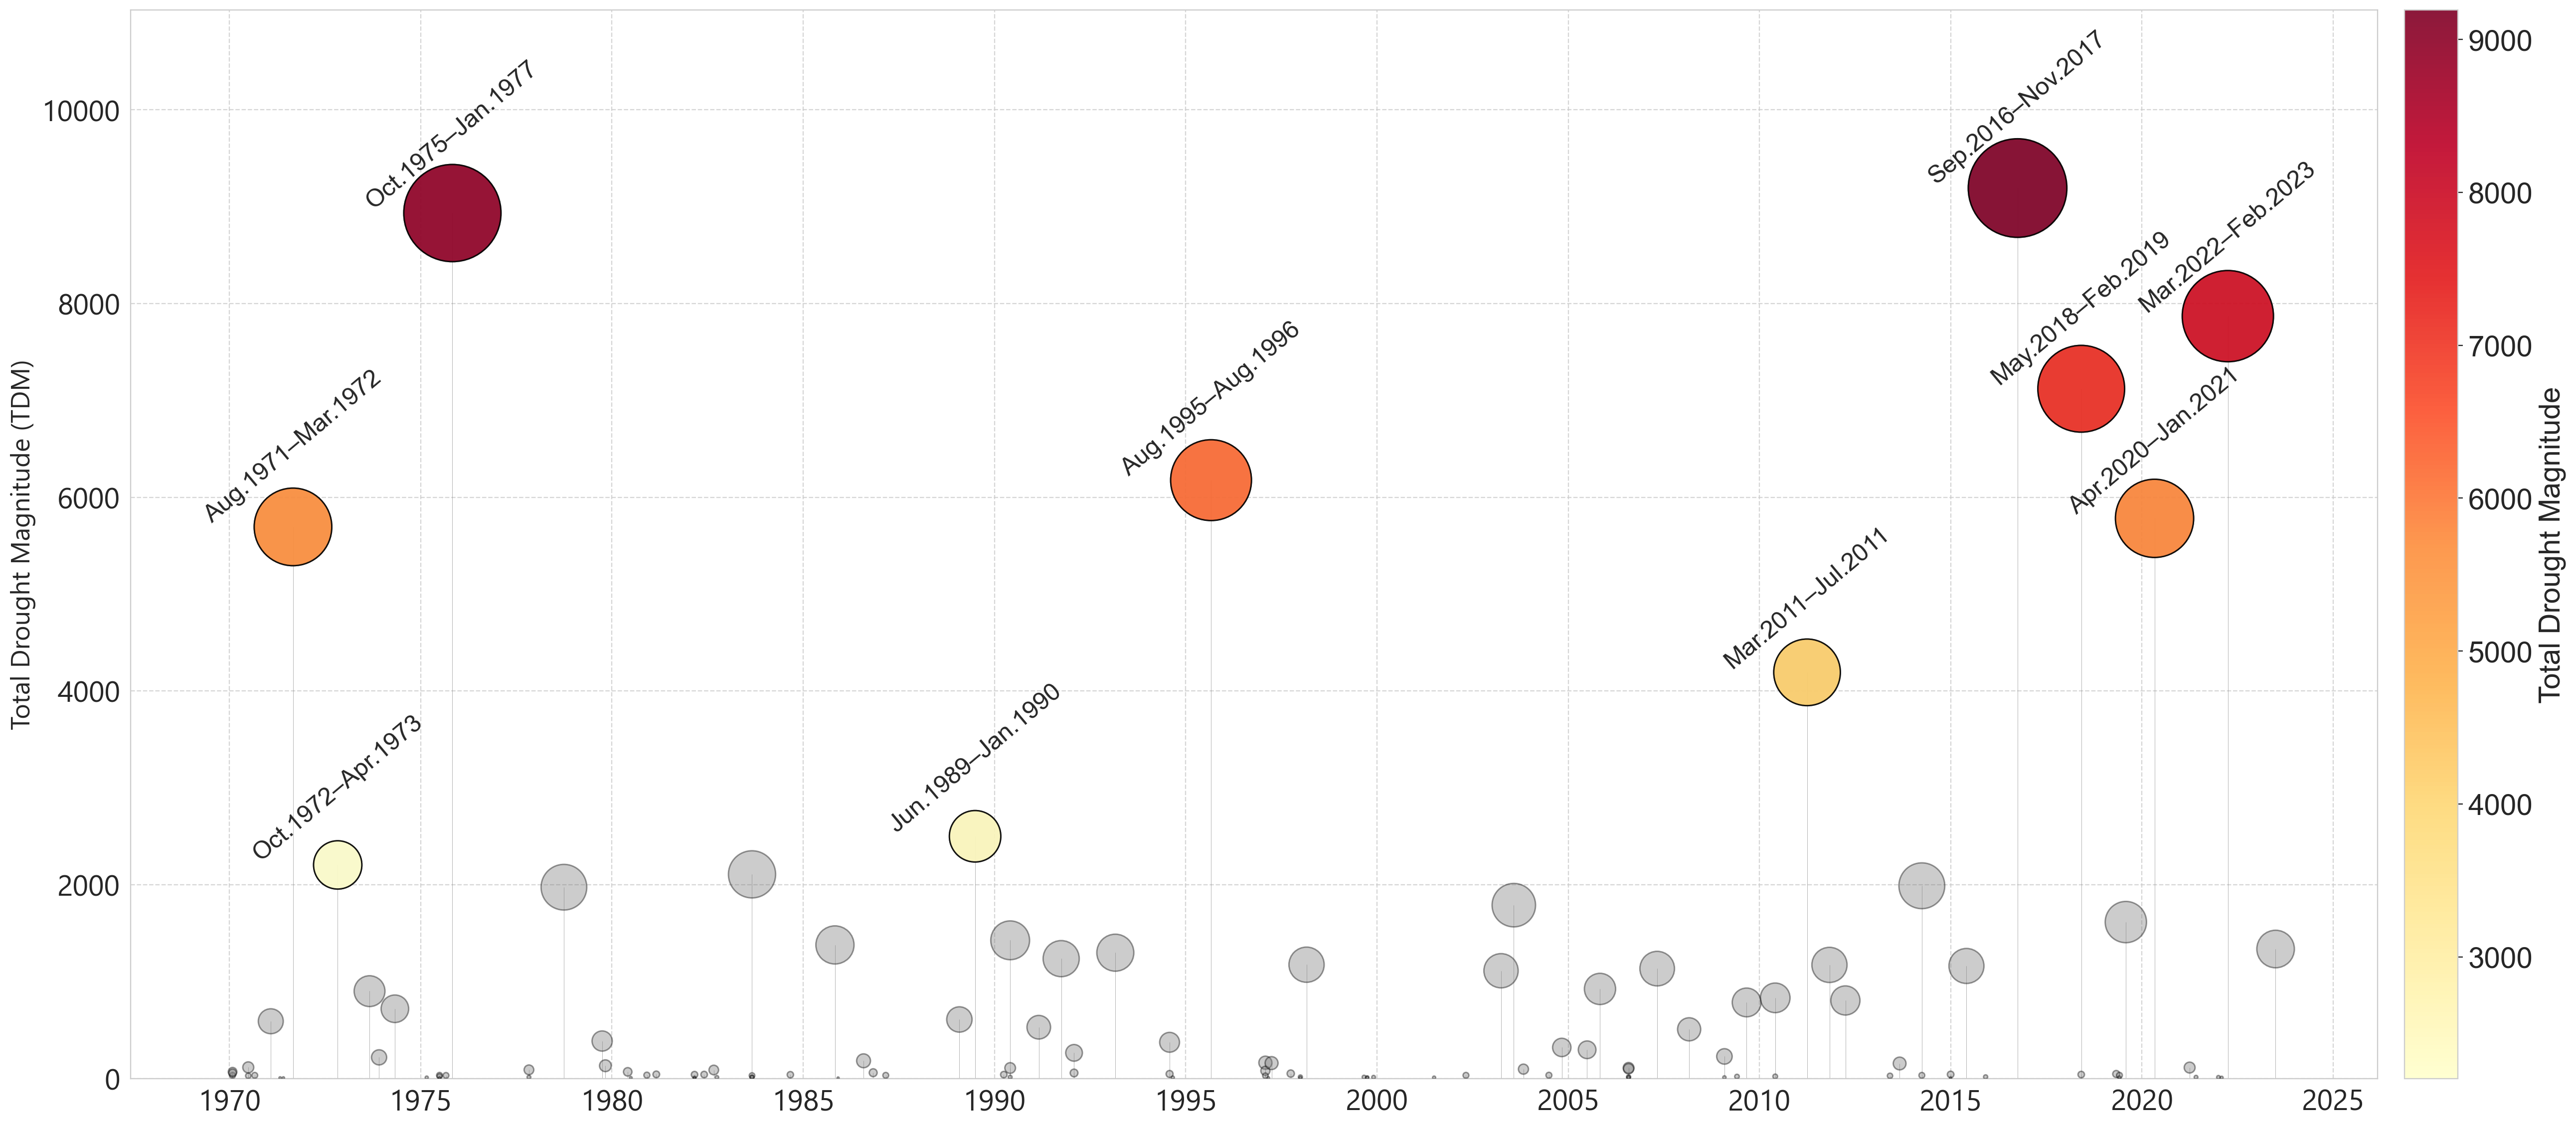

In [61]:
#Plot the drought events using the defined lollipop plot function
plot = ADM_lolliplot_TDM(drought_ADM, top_n_events=10)

### Cluster Drought Classes
For all SMI classes, group the SMI into percentile classes to plot decadal stacked area charts for comparison

The drought classes are based on The Drought Monitor (Svoboda et al., 2002)

In [62]:
variable = 'SMI'

#Mask the SMI data to ignore areas with zero variance i.e. areas with no valida data
#This happens when some parts of the domain where precipitation was missing and were filled with zeros
# to make sure meteo inputs cover all parts of the DEM
smi_EOBS_domain = smi_EOBS_masked.where(smi_EOBS_masked.SMI.var(dim='time') > 0.001, drop=False)

# Define the percentile classes and their corresponding labels
bounds = [0.00, 0.02, 0.05, 0.10, 0.20, 0.30, 0.70, 0.95, 0.98, 1.0]
labels = ['Exceptional drought', 'Extreme drought', 'Severe drought',
          'Moderate drought', 'Abnormally dry','Normal conditions',
          'Wetter than normal', 'Very wet', 'Extremely wet']



# Calculate the percentiles
smi_percentile_df = mdf.cluster_percentiles(smi_EOBS_domain, variable, bounds, labels)

Repeat the same procedure but to cluster only the pixels in drought (where SMI<0.2)

In [63]:
#calculate percentiles for drought events only
smi_drought = smi_EOBS_domain.where(smi_EOBS_domain.SMI <= .2, drop=False)

# Define the percentiles. 
# the max value is set to 0.2 which is the threshold that was defined during the SMI analysis
drought_thresholds = [0.00, 0.02, 0.05, 0.10, 0.20]
labels = ['Exceptional drought', 'Extreme drought', 'Severe drought',
          'Moderate drought']

# Cluster the drought pixesls into the respective drought classes
drought_percentile_df = mdf.cluster_percentiles(smi_drought, variable, drought_thresholds, labels)

#### Analysis of decadal drought patterns
For each decade we analyze;  
>> 1.)  The proportion of area affected by the respective drought severities,  

In [64]:
#categories by decade
decades = ['1971-1980', '1981-1990', '1991-2000', '2001-2010', '2011-2020']
variable = 'SMI'

#use the decadal drought area function to calculate the area affected by each drought category for each decade
drought_area_df = mdf.decadal_drought_area(smi_drought, decades, variable, drought_thresholds, labels)

#### Plotting stacked area and donut charts

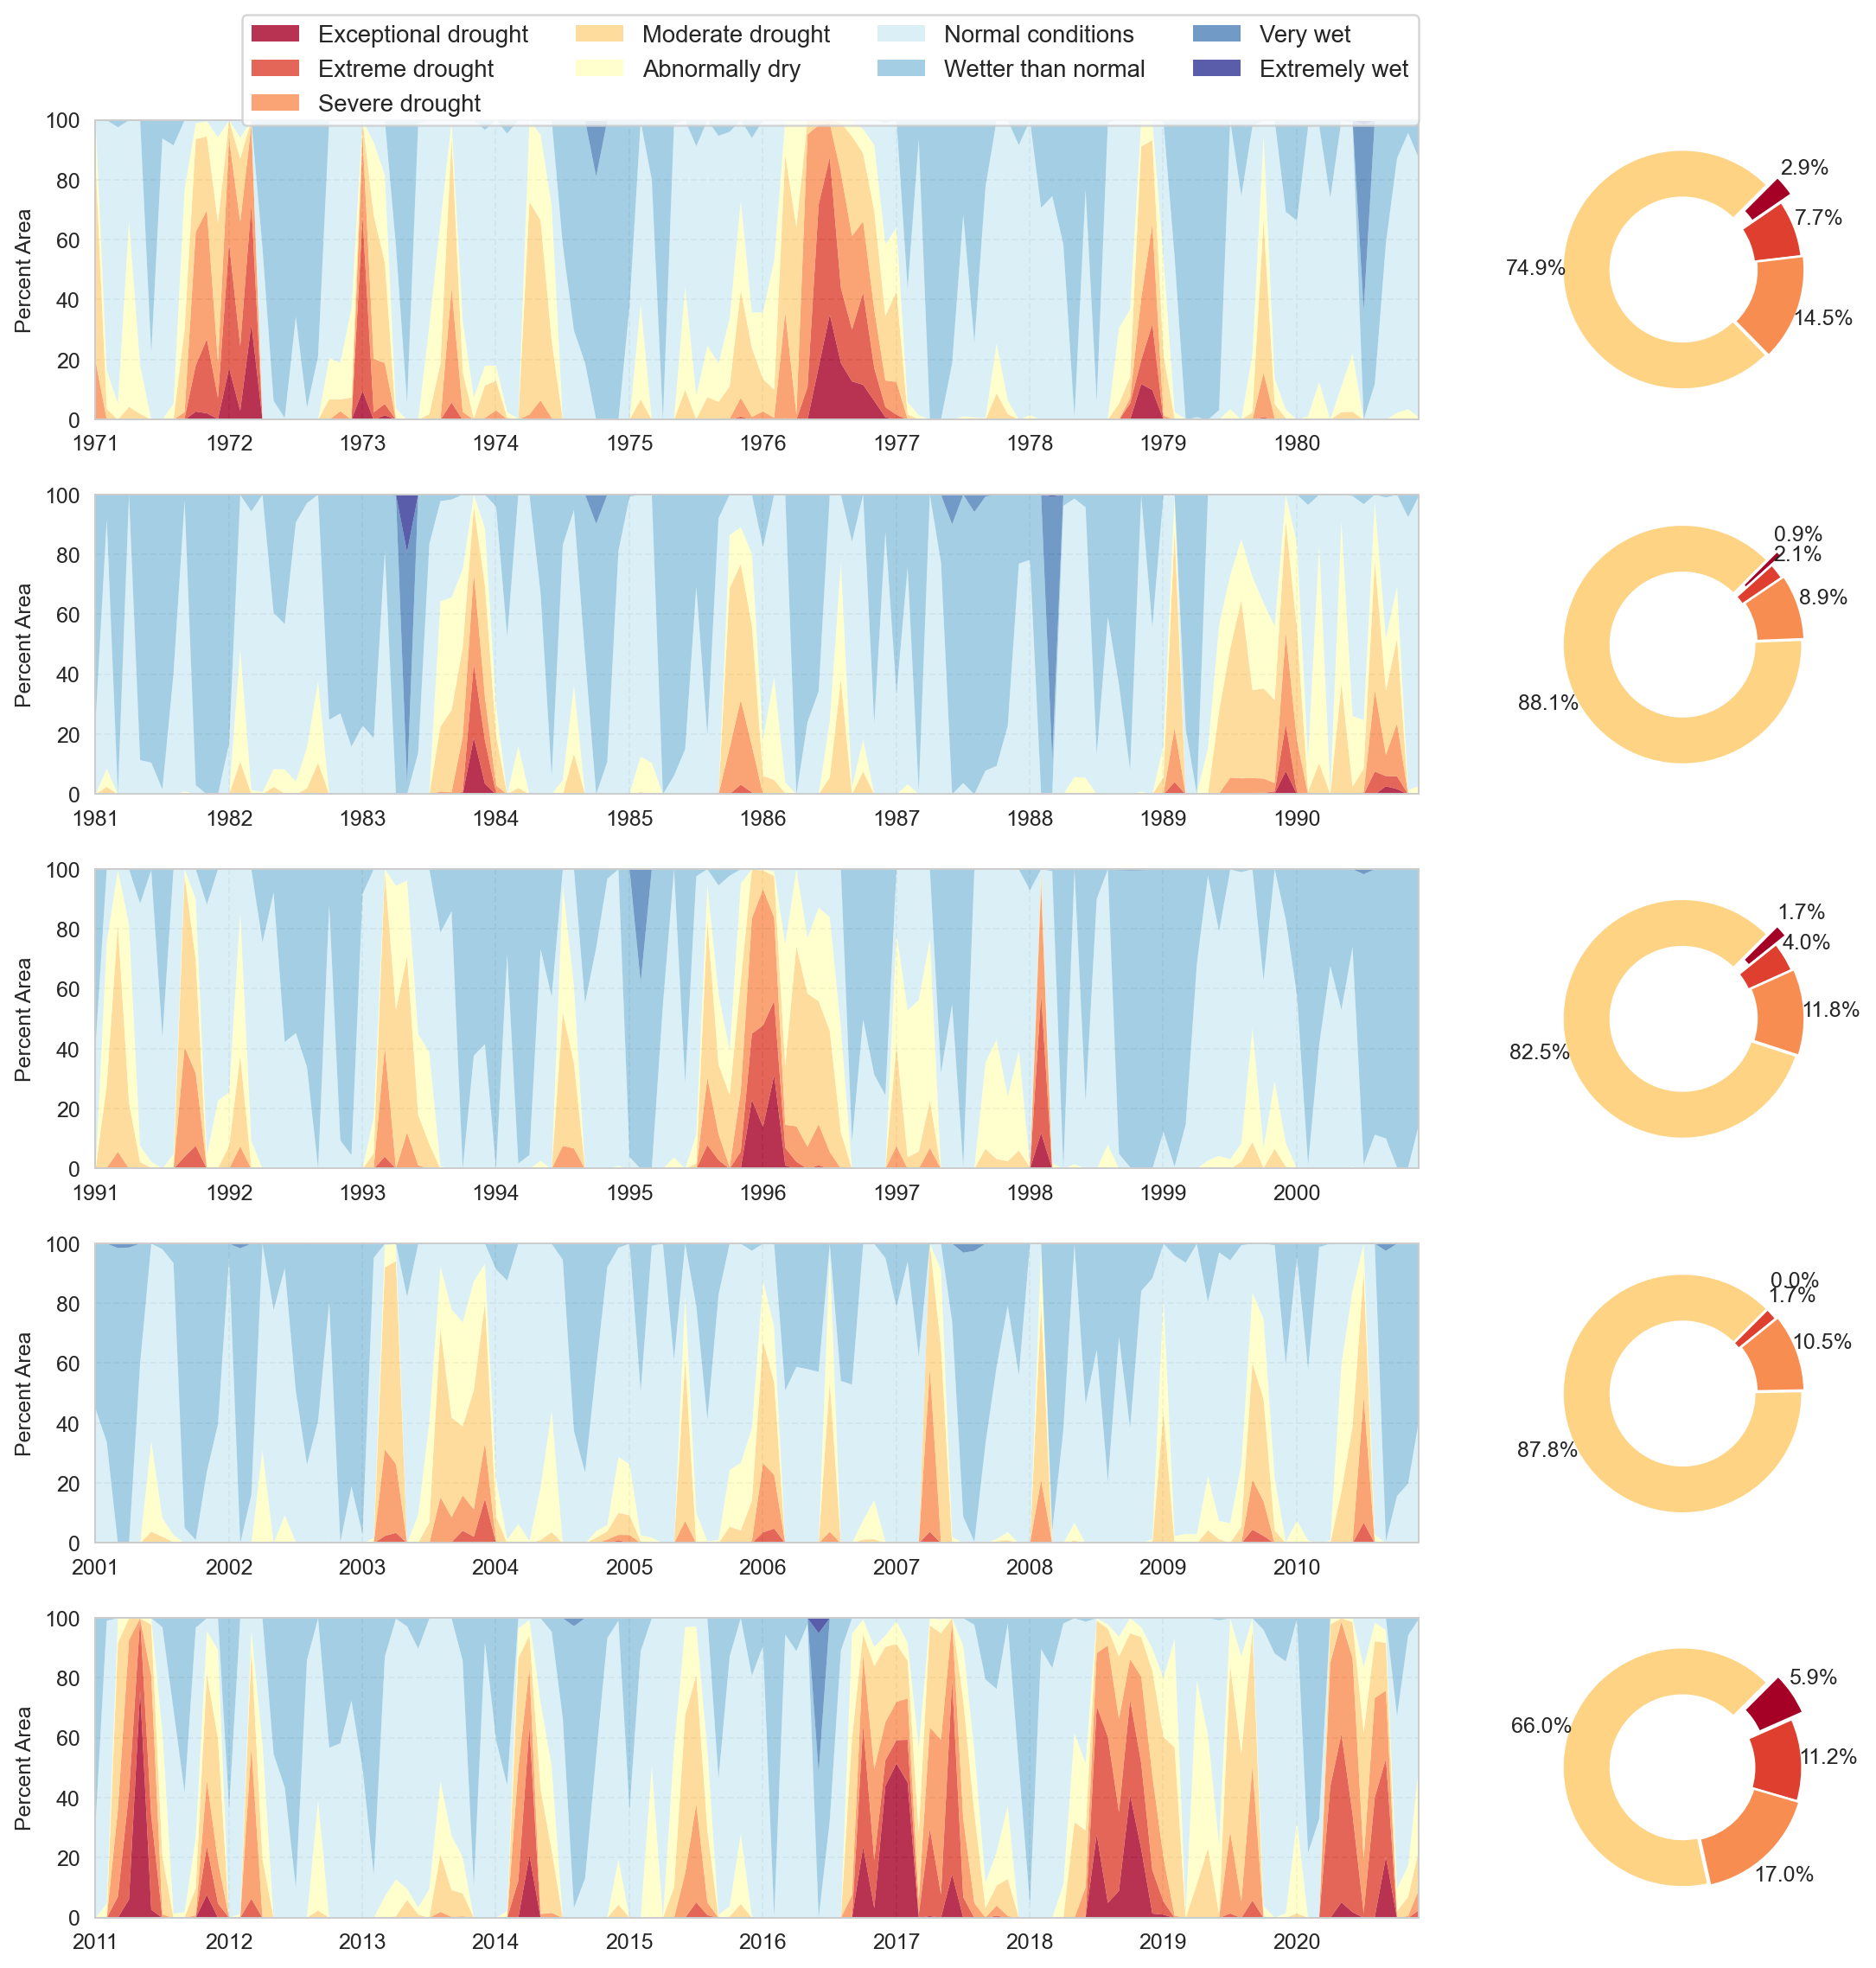

In [65]:
# List of decades
decades = ['1971-1980', '1981-1990', '1991-2000', '2001-2010', '2011-2020']

# Set up figure
fig = plt.figure(figsize=(15, 15), dpi=180)
gs = GridSpec(5, 2, figure=fig, width_ratios=[3.0, 1], hspace=0.25, wspace=0.05)

labels = ['D4', 'D3', 'D2', 'D1']
explode = (0.1, -0.01, 0.01, 0.01)


#RdYlBu colormap
colors = ['#a50026', '#de3f2e', '#f88d52', '#fed384', '#ffffbf']

# Loop through decades and plot
for i, (decade, (decade_str, row)) in enumerate(zip(decades, drought_area_df.iterrows())):
    start_year, end_year = map(int, decade.split('-'))
    smi_decade = smi_percentile_df.loc[f'{start_year}':f'{end_year}']

    # Area plot
    ax_area = fig.add_subplot(gs[i, 0])
    smi_decade.plot.area(colormap='RdYlBu', ax=ax_area, linewidth=0, alpha=0.8)
    ax_area.set_ylim(0, 100)
    ax_area.set_ylabel('Percent Area')
    ax_area.set_xlabel('')
    #add xticks
    ax_area.grid(True, linestyle='--', alpha=0.8)

    # Only show legend once
    if i == 0:
        ax_area.legend(loc='upper left', bbox_to_anchor=(0.102, 1.39), ncols=4, fontsize=11)
    else:
        ax_area.get_legend().remove()

    # Donut plot
    ax_donut = fig.add_subplot(gs[i, 1], aspect='equal')
    wedges, texts, autotexts = ax_donut.pie(
        row.values,
        startangle=45,
        counterclock=False,
        colors=colors,
        explode=explode,
        autopct=lambda p: f'{p:.1f}%',
        pctdistance=1.22,
        wedgeprops=dict(width=0.4)
    )
    # Remove axis ticks for clean look
    ax_donut.set_xticks([])
    ax_donut.set_yticks([])

plt.show()


>>2.) The duration of occurence of each class in months  

In [66]:
#For this analysis we slightly modify the drought classes so that it is a dictionary with the class names as keys
#  and the thresholds as a tuple.
drought_classes = {
    'Exceptional drought': (0.00, 0.02),
    'Extreme drought': (0.02, 0.05),
    'Severe drought': (0.05, 0.10),
    'Moderate drought': (0.10, 0.20),
}

decade_drought_durs = mdf.decadal_duration_category(smi_EOBS_domain, decades, drought_classes)

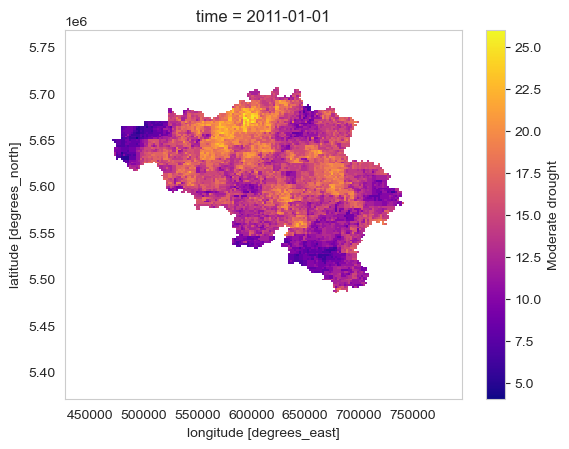

In [67]:
decade_drought_durs['2011-2020']['Moderate drought'].plot(cmap='plasma')

#### Decadal duration of droughts

For each decade, compute the total duration (months) that each pixel has experienced drought.  
This is not specific to any type of drought

In [68]:
#calculate percentiles for drought events only
smi_drought = smi_EOBS_masked.where(smi_EOBS_masked.SMI <= .2, drop=False)

# Define the percentiles
bounds = [0.00, 0.02, 0.05, 0.10, 0.20]
labels = ['Exceptional drought', 'Extreme drought', 'Severe drought',
          'Moderate drought']

In [69]:
decadal_category_map = mdf.cluster_percentiles_pixelwise(smi_EOBS_domain, 'SMI', bounds)
decadal_durations, decadal_categories = mdf.decadal_drought_clusters(decades, smi_EOBS_domain, bounds)

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [70]:
decadal_durations, decadal_categories = mdf.decadal_drought_clusters(decades, smi_EOBS_domain, bounds)

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [71]:
smi_var = smi_EOBS_masked['SMI'].var(dim='time')
zero_var_mask = smi_var == 0


C:\Users\kart\AppData\Local\Temp\ipykernel_18840\2039443915.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


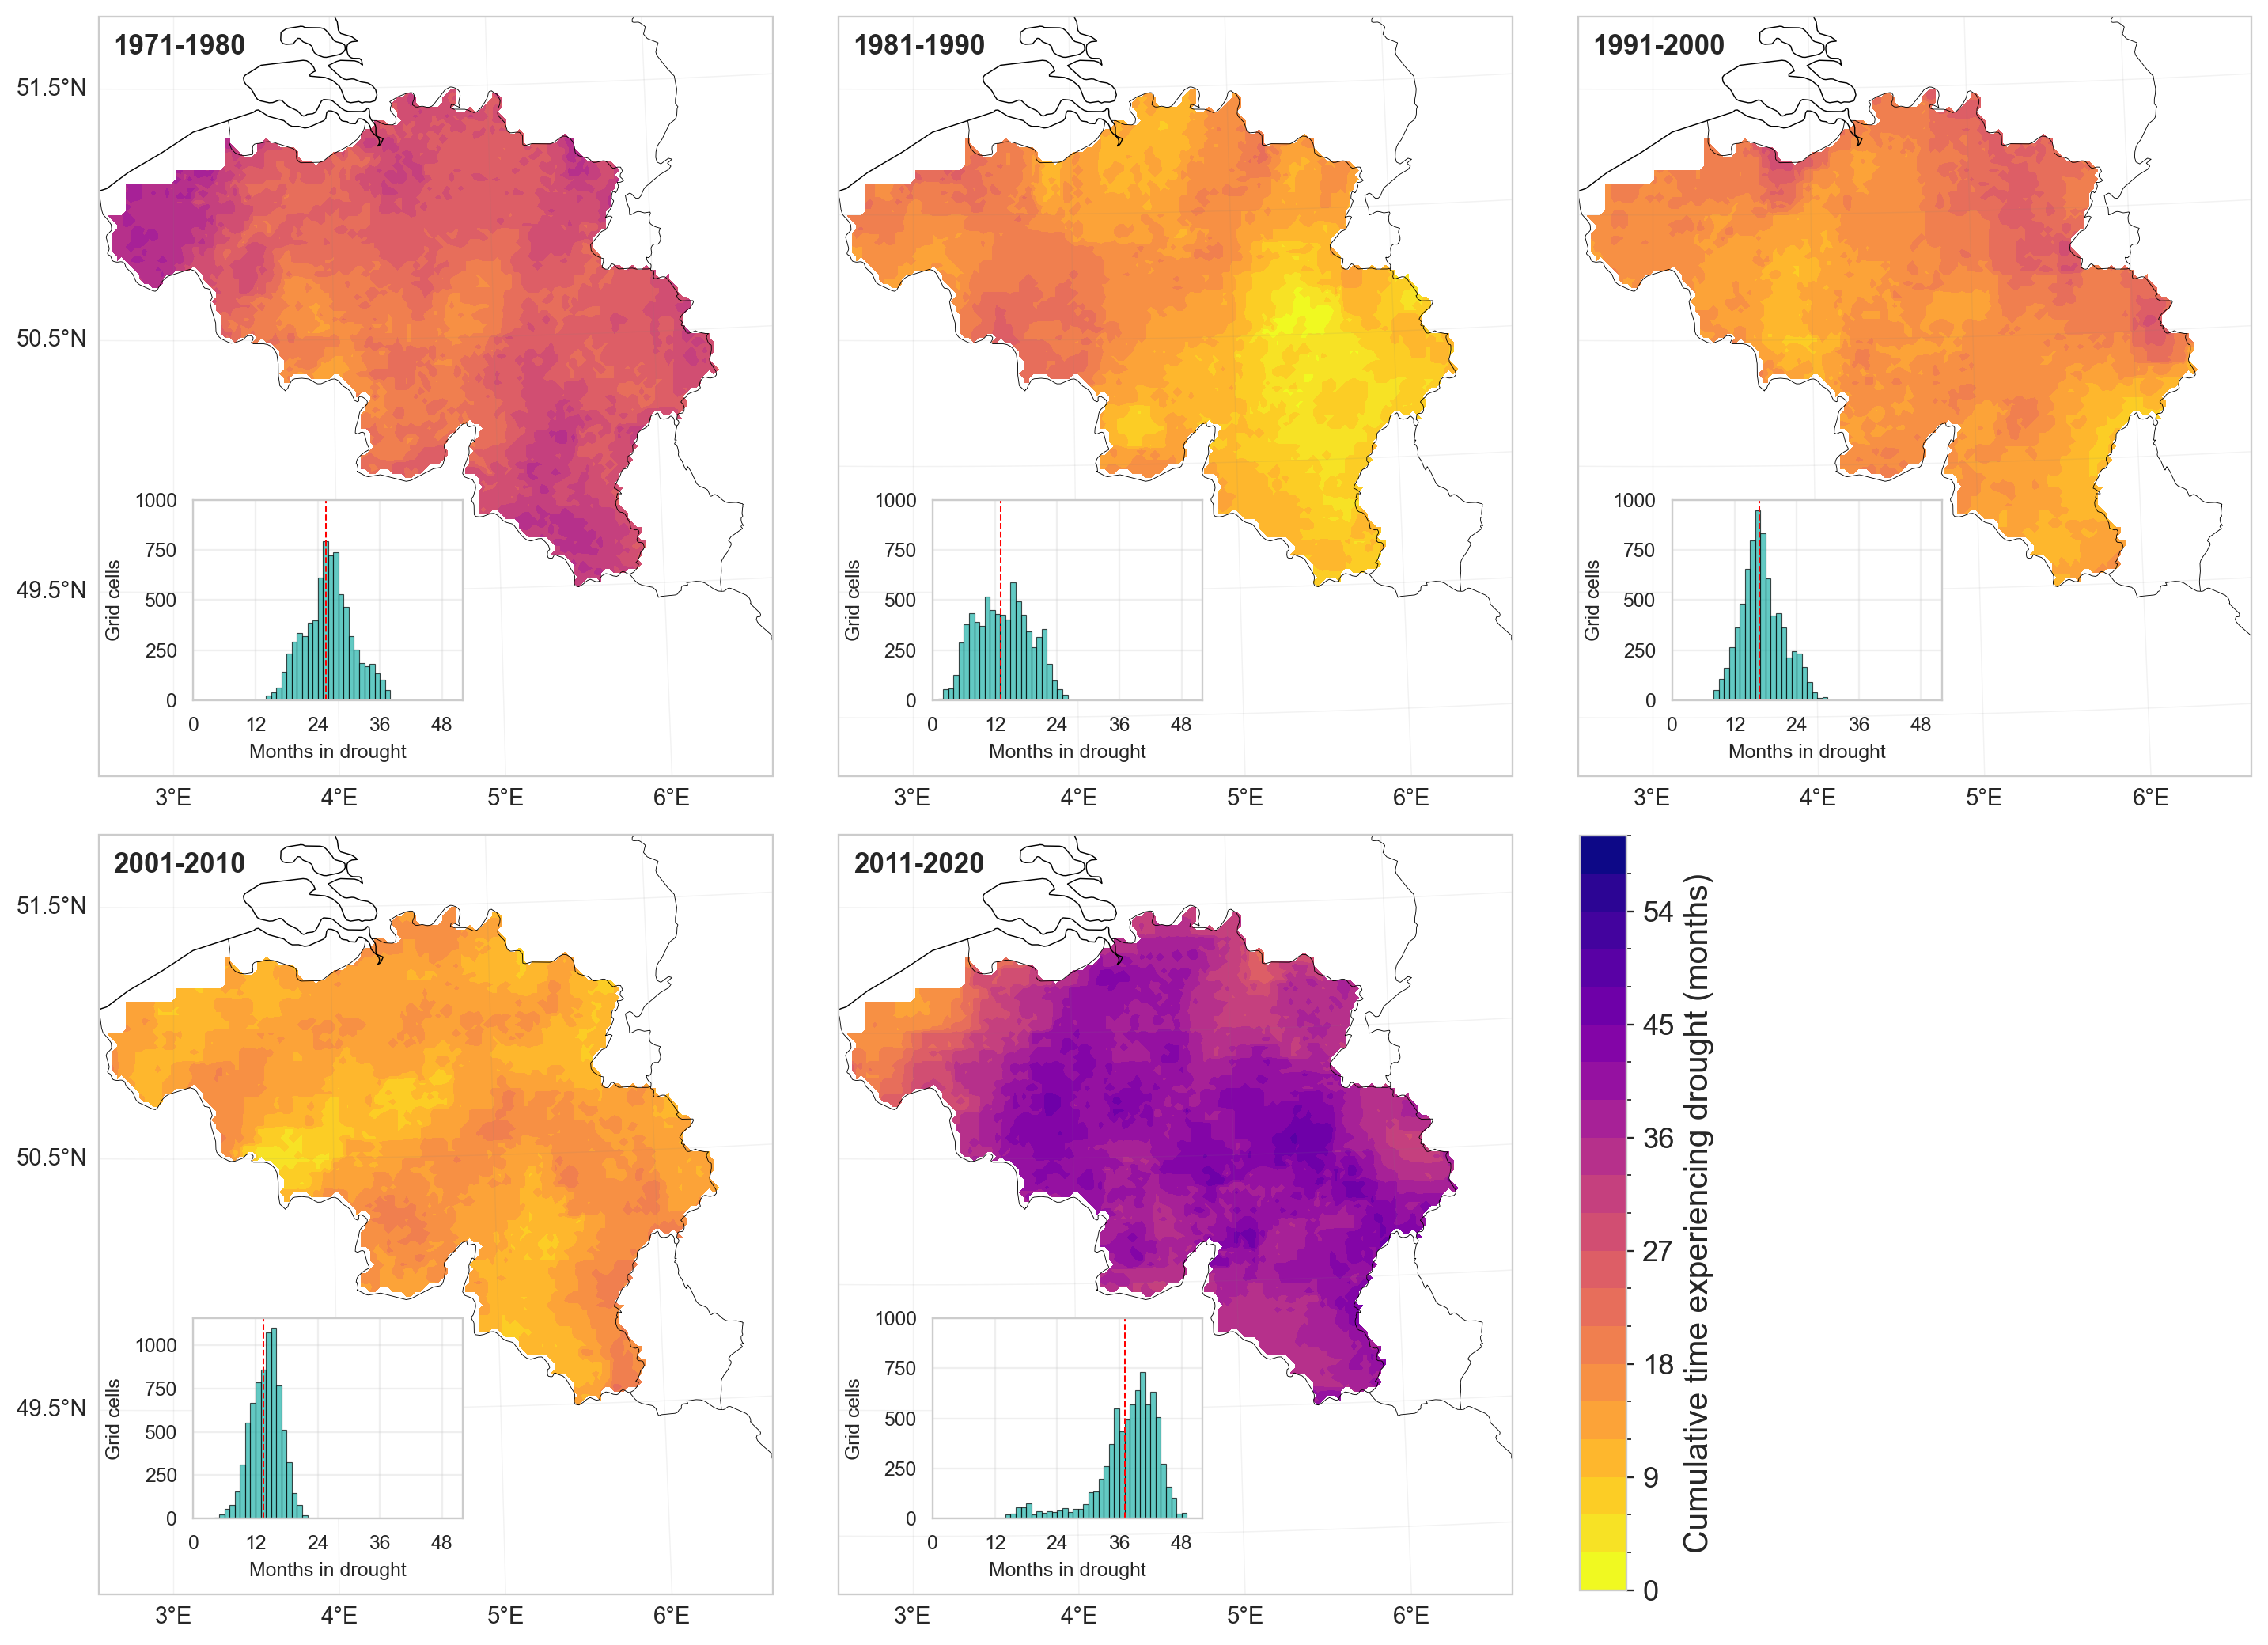

In [101]:
# Setup: 3 rows × 2 columns (6 slots, last one removed)
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(14, 10), dpi=210,
    subplot_kw={'projection': ccrs.epsg(32631)}
)
axes = axes.flatten()

vmin, vmax = 0, 61
levels = np.arange(vmin, vmax, 3)

for i, (decade, maps) in enumerate(decadal_durations.items()):
    d_map = maps['D1_to_D4']
    d_map = d_map.where(~np.isnan(smi_EOBS_masked['SMI'][0]))  # mask invalid data

    grid_res= (d_map.lat[0] - d_map.lat[1]).values.item()  # Get grid resolution from latitude values
    lat_min, lat_max = d_map.lat.min()+ grid_res*15, d_map.lat.max()-grid_res*15

    lon_min, lon_max = d_map.lon.min()+ grid_res*20, d_map.lon.max()-grid_res*15

    d_extent = d_map.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))


    ax = axes[i]
    
    # Plot drought duration map
    im = d_extent.plot.contourf(
        ax=ax,
        cmap='plasma_r',
        transform=ccrs.epsg(32631),
        add_colorbar=False,
        robust=True,
        vmin=vmin,
        vmax=vmax,
        levels=levels,
        extend='neither'
    )
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Add x gridlines to first and second row only
    if i == 0 or i == 3:
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True,
            linewidth=0.5,
            #label spacing
            xlocs=np.arange(2, 6.5, 1),
            ylocs=np.arange(48.5, 52, 1.0),
            color='gray',
            alpha=0.1
        )
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = True
    
    else:
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=False,
            linewidth=0.5,
            color='gray',
            alpha=0.1
        )
        gl.bottom_labels = True


    ax.set_title("")
    ax.text(0.12, 0.95, f'{decade}',
            transform=ax.transAxes, ha='center', fontsize=12, fontweight='bold')

    # Add inset histogram
    inset_ax = inset_axes(
    ax,
    width="40%",
    height="22%",
    loc='lower left',
    bbox_to_anchor=(0.14, 0.10, 1, 1.2), # (x0, y0, width, height) relative to the ax
    bbox_transform=ax.transAxes,
    borderpad=0
)

    # Prepare histogram data
    flat = d_map.values.flatten()
    flat = flat[~np.isnan(flat)]
    flat = flat[flat > 0]  # ignore zero-duration pixels

    if len(flat) > 0:
        bins = np.arange(int(flat.min()), int(flat.max()) + 1 ,1.0)
        mean_duration = np.mean(flat)
        inset_ax.set_title(f'')
        inset_ax.hist(flat, bins=bins, color='lightseagreen', edgecolor='black', linewidth=0.4, alpha=0.7)
        inset_ax.axvline(mean_duration, color='red', linestyle='--', linewidth=0.7)
        inset_ax.set_xticks(np.arange(0, 50, 12))
        inset_ax.set_yticks(np.arange(0, 1010, 250))
        inset_ax.tick_params(axis='x', labelsize=8.5)
        inset_ax.tick_params(axis='y', labelsize=8.5)
        inset_ax.set_ylabel('Grid cells', fontsize=8.5)
        inset_ax.set_xlim(0, 52)
        inset_ax.grid(True, alpha=0.3)
        inset_ax.set_xlabel('Months in drought', fontsize=8.5)
        

# Remove unused subplot
fig.delaxes(axes[-1])

# Shared colorbar with bottom orientation
# Create a new axes for the colorbar
cbar_ax = fig.add_axes([0.69, 0.038, 0.02, 0.454]) #left, bottom, width, height

cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Cumulative time experiencing drought (months)', fontsize=14)
cbar_ax.tick_params(labelsize=12.5)  # adjust tick label size here


plt.tight_layout()
plt.show()

In [73]:
# Calculate variance mask for graying out areas with very low variance of SMI
threshold = 0.001  # Adjust as needed for "very low variance"
smi_var = smi_EOBS_masked['SMI'].var(dim='time')
zero_var_mask = (smi_var < threshold).fillna(False)

C:\Users\kart\AppData\Local\Temp\ipykernel_18840\575671511.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


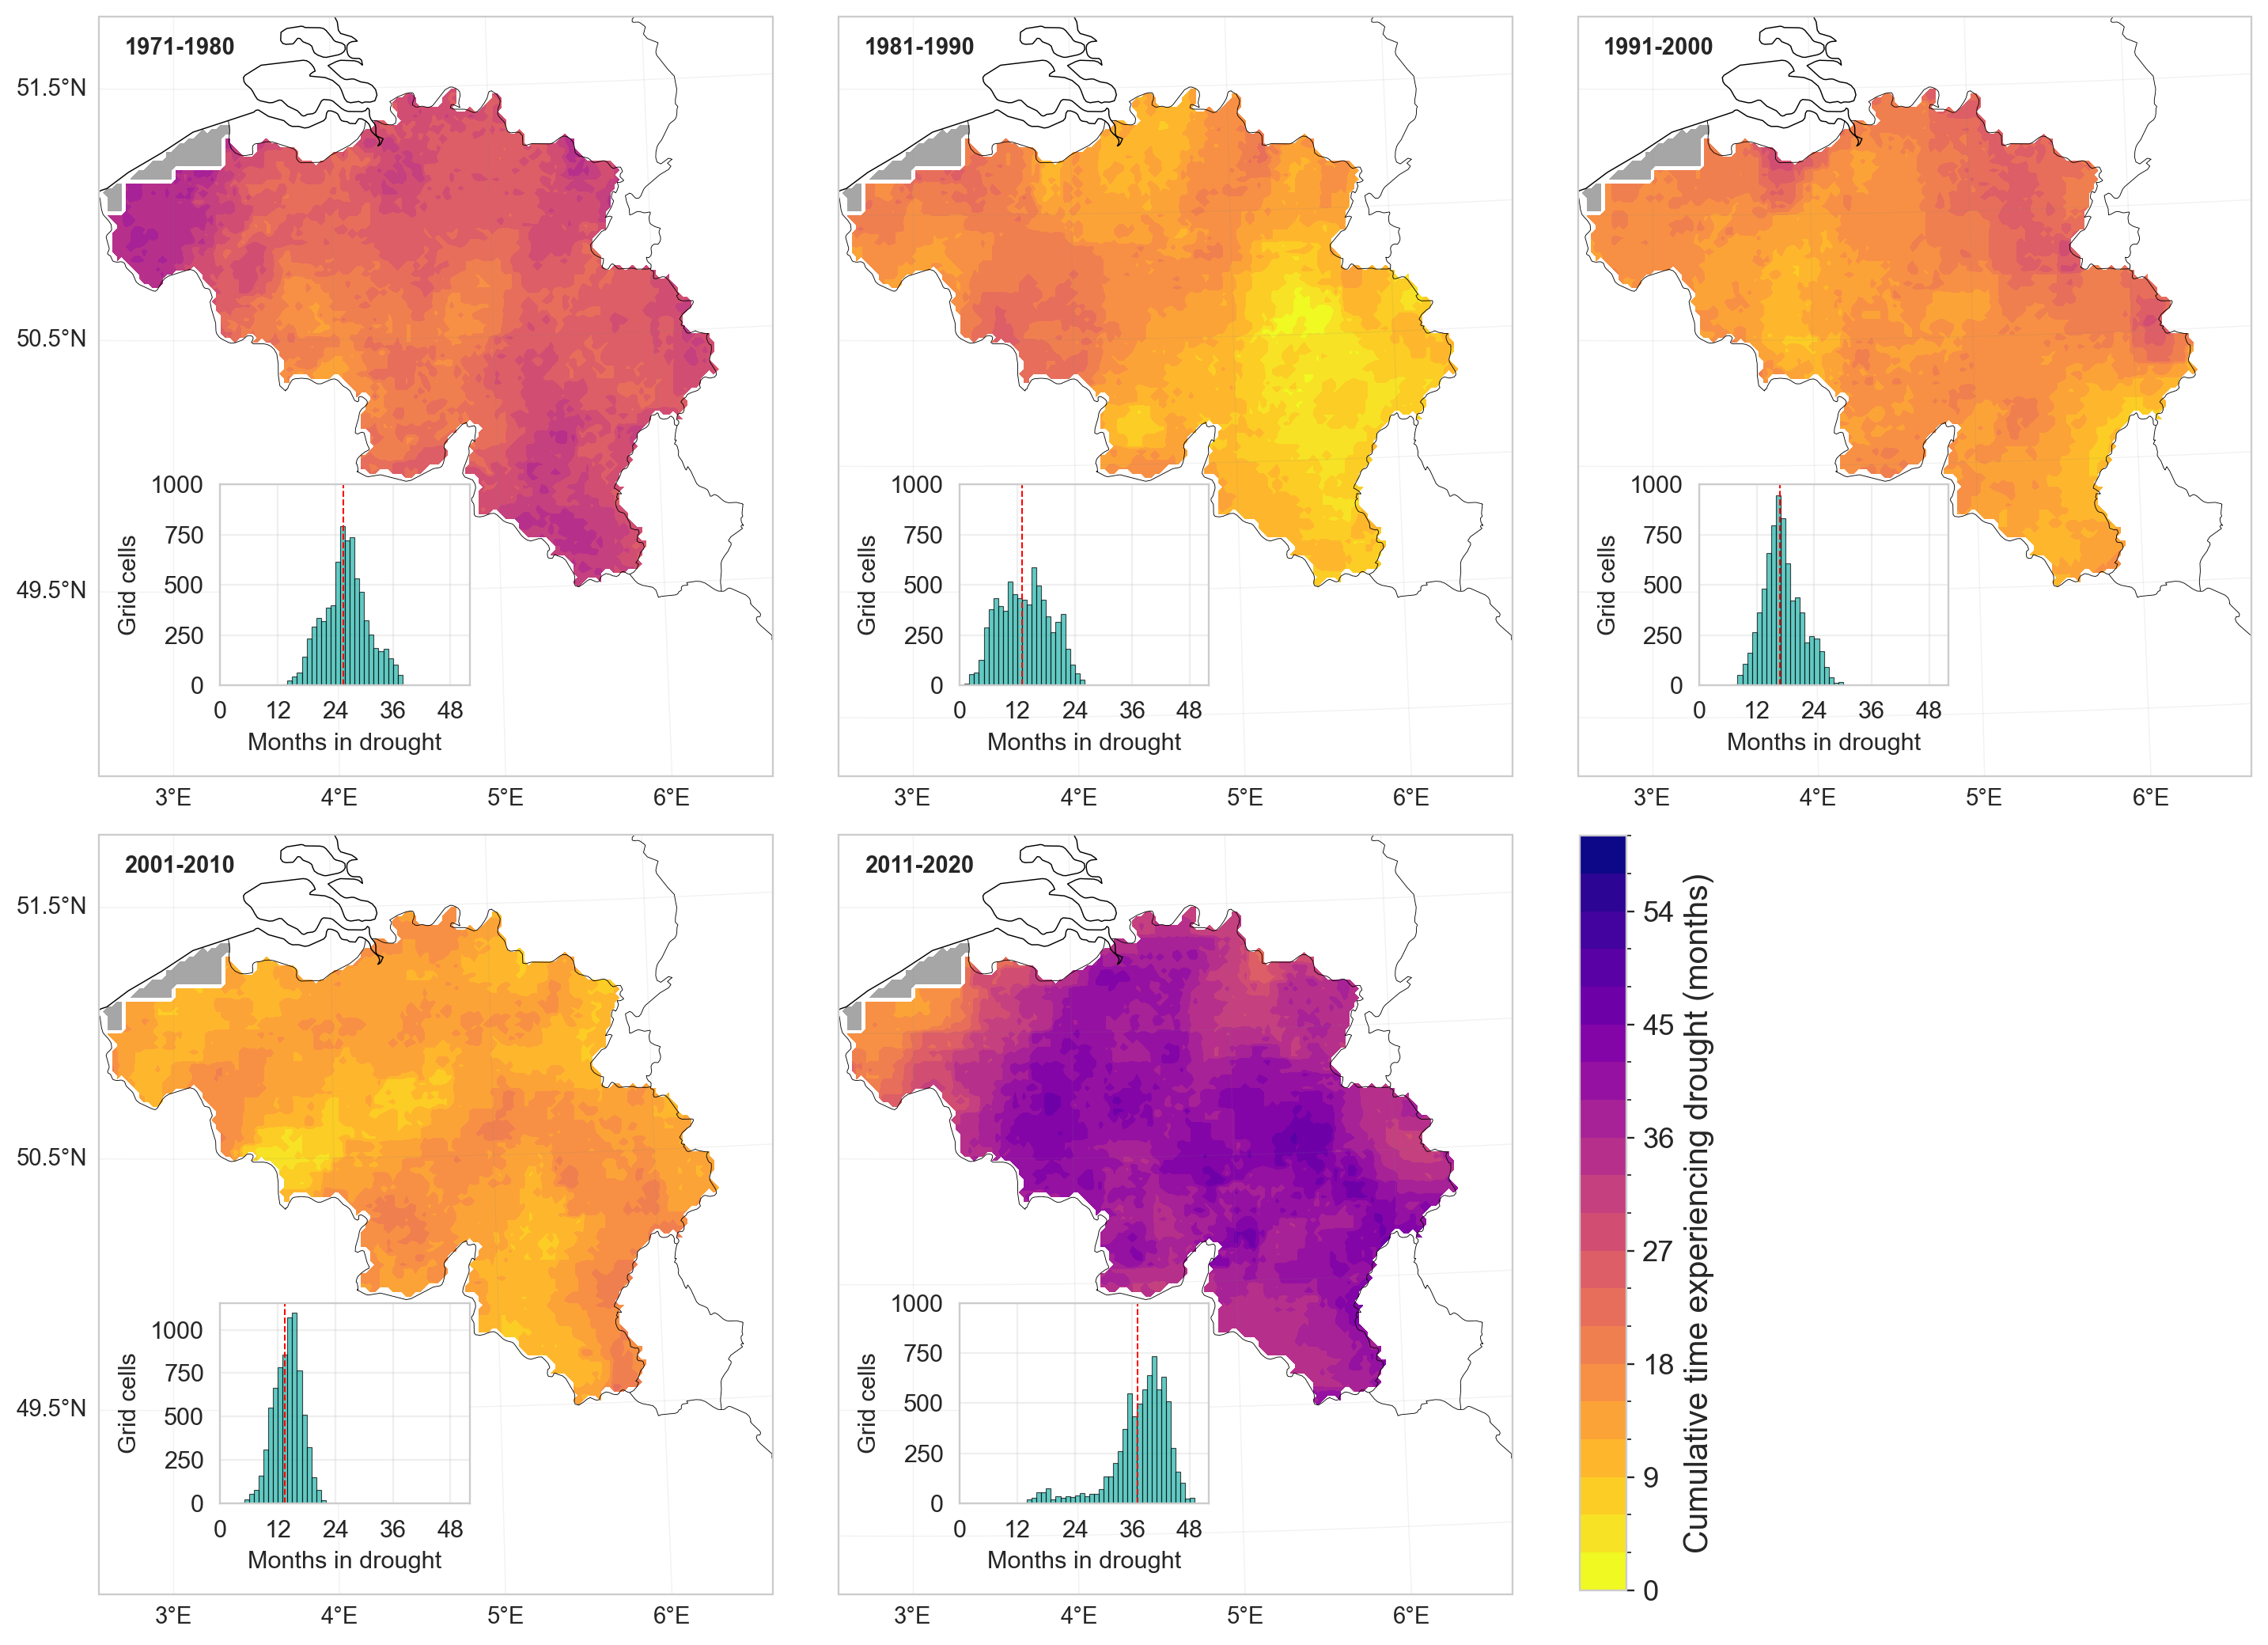

In [102]:
# Setup: 2 rows × 3 columns (6 slots, last one removed)
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(14, 10), dpi=210,
    subplot_kw={'projection': ccrs.epsg(32631)}
)
axes = axes.flatten()

vmin, vmax = 0, 61
levels = np.arange(vmin, vmax, 3)

for i, (decade, maps) in enumerate(decadal_durations.items()):
    d_map = maps['D1_to_D4']
    d_map = d_map.where(~np.isnan(smi_EOBS_masked['SMI'][0]))  # mask invalid data

    grid_res = (d_map.lat[0] - d_map.lat[1]).values.item()
    lat_min, lat_max = d_map.lat.min() + grid_res*15, d_map.lat.max() - grid_res*15
    lon_min, lon_max = d_map.lon.min() + grid_res*20, d_map.lon.max() - grid_res*15

    d_extent = d_map.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
    zero_var_subset = zero_var_mask.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

    # Convert boolean mask to float and mask out False as NaN for plotting
    zero_var_subset_plot = zero_var_subset.astype(float).where(zero_var_subset)

    ax = axes[i]

    # Plot drought duration map
    im = d_extent.plot.contourf(
        ax=ax,
        cmap='plasma_r',
        transform=ccrs.epsg(32631),
        add_colorbar=False,
        robust=True,
        vmin=vmin,
        vmax=vmax,
        levels=levels,
        extend='neither'
    )

    # Overlay hatching for low variance regions
    zero_var_subset_plot.plot.contourf(
        ax=ax,
    transform=ccrs.epsg(32631),
    colors=['gray'],
    add_colorbar=False,
    alpha=0.7  # Adjust transparency as needed
)

    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

    # Gridlines
    if i == 0 or i == 3:
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True,
            linewidth=0.5,
            xlocs=np.arange(2, 6.5, 1),
            ylocs=np.arange(48.5, 52, 1.0),
            color='gray',
            alpha=0.1
        )
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = True
    else:
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=False,
            linewidth=0.5,
            color='gray',
            alpha=0.1
        )
        gl.bottom_labels = True

    ax.set_title("")
    ax.text(0.12, 0.95, f'{decade}',
            transform=ax.transAxes, ha='center', fontsize=10, fontweight='bold')

    # Add inset histogram
    inset_ax = inset_axes(
        ax,
        width="37%",
        height="22%",
        loc='lower left',
        bbox_to_anchor=(0.18, 0.12, 1, 1.2), # (x0, y0, width, height) relative to the ax
        bbox_transform=ax.transAxes,
        borderpad=0
    )

    flat = d_map.values.flatten()
    flat = flat[~np.isnan(flat)]
    flat = flat[flat > 0]

    if len(flat) > 0:
        bins = np.arange(int(flat.min()), int(flat.max()) + 1, 1.0)
        mean_duration = np.mean(flat)
        inset_ax.hist(flat, bins=bins, color='lightseagreen', edgecolor='black', linewidth=0.4, alpha=0.7)
        inset_ax.axvline(mean_duration, color='red', linestyle='--', linewidth=0.7)
        inset_ax.set_xticks(np.arange(0, 50, 12))
        inset_ax.set_yticks(np.arange(0, 1010, 250))
        inset_ax.tick_params(axis='x', labelsize=10.5)
        inset_ax.tick_params(axis='y', labelsize=10.5)
        inset_ax.set_ylabel('Grid cells', fontsize=10.5)
        inset_ax.set_xlim(0, 52)
        inset_ax.grid(True, alpha=0.3)
        inset_ax.set_xlabel('Months in drought', fontsize=10.5)

# Remove unused subplot
fig.delaxes(axes[-1])

# Shared colorbar
cbar_ax = fig.add_axes([0.69, 0.038, 0.02, 0.454]) #left, bottom, width, height

cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Cumulative time experiencing drought (months)', fontsize=14)
cbar_ax.tick_params(labelsize=12.5)  # adjust tick label size here

plt.tight_layout()
plt.show()


#### Bootstrapping decadal durations

In [ ]:
def create_bootstrap_samples(t_drought, sm_var, sample_size, n_samples = 1000):
    """    Create bootstrap samples from a given dataset.
    Parameters:
    - t_drought: DataFrame containing the drought data.
    - sm_var: The variable to sample from.
    - sample_size: The size of each bootstrap sample.
    - n_samples: The number of bootstrap samples to create (default is 1000).
    Returns:
    - A Pandas Series containing the means of the bootstrap samples

    """
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in range(n_samples):
        
        # create a bootstrap sample of sample_size with replacement
        df_bootstrap_sample = t_drought[sm_var].sample(sample_size, replace = True)
        
        # calculate the bootstrap sample mean
        sample_mean = df_bootstrap_sample.mean()
        
        # add this sample mean to the sample means list
        sample_means.append(sample_mean)
    
    return pd.Series(sample_means)

In [183]:
#Extract cumulative time in drought for each decade
t_mean_decades = {}
for decade in decades:
    t_drought=decadal_durations[decade]['D1_to_D4'].to_dataframe().reset_index().drop(columns=['lat', 'lon','time']).dropna()

    # Create bootstrap samples
    tmean_decade = create_bootstrap_samples(t_drought, len(t_drought), n_samples=7000)

    # Store the bootstrap sample means in the dictionary
    t_mean_decades[decade] = tmean_decade

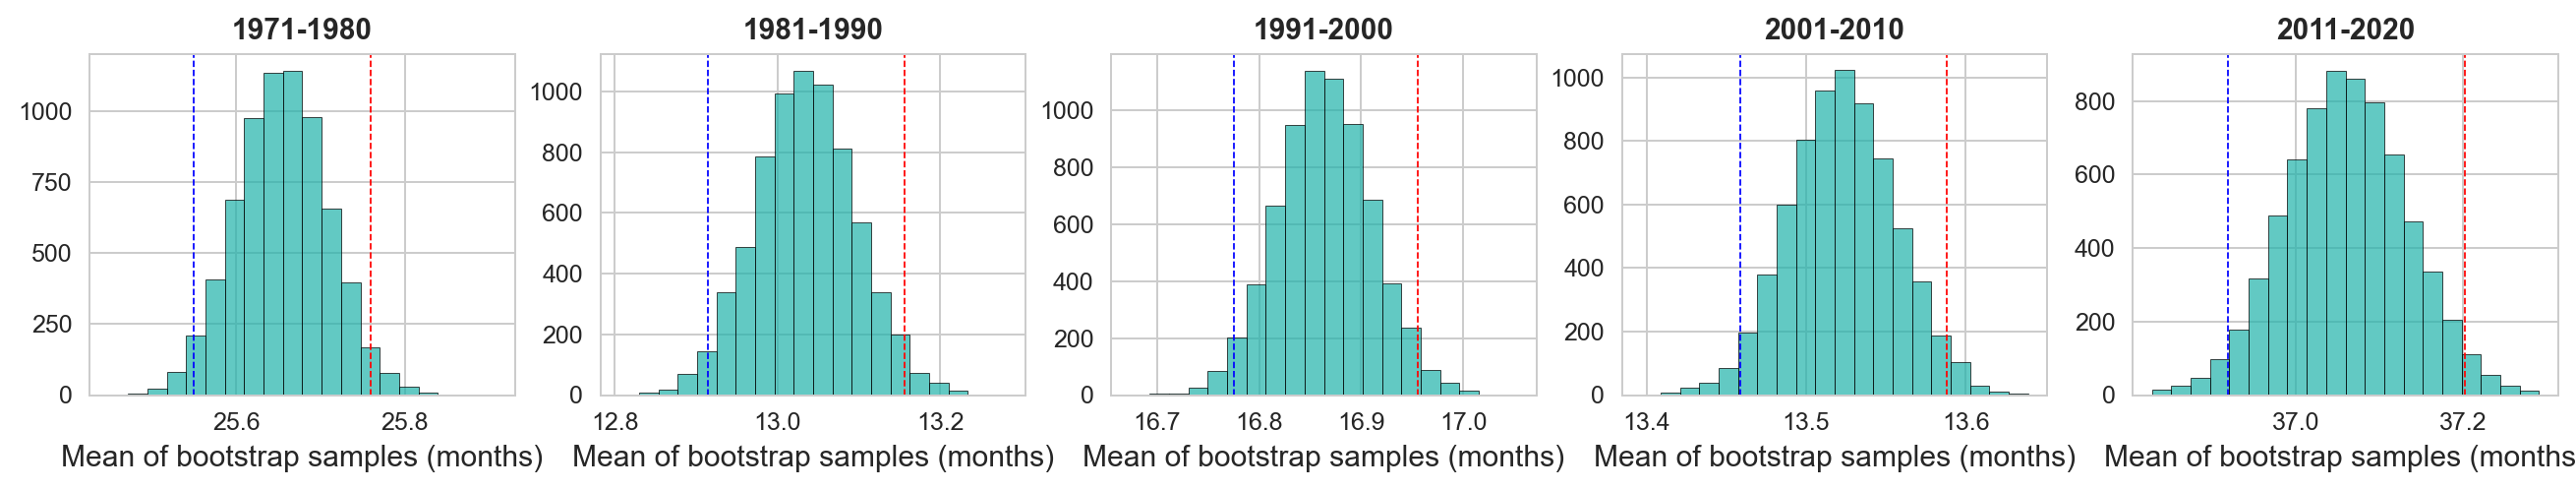

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(18, 2.5), dpi=180)
axes = axes.flatten()

#set hspace


# plot the distribution
for i, (decade, ax) in enumerate(zip(decades, axes)):
    t_decade = t_mean_decades[decade]
    ci_lower = t_decade.quantile(0.025)
    ci_upper = t_decade.quantile(0.975)
    ax.hist(t_decade, bins=20, color='lightseagreen', edgecolor='black', linewidth=0.4, alpha=0.7);
    ax.axvline(ci_lower, color='blue', linestyle='--', linewidth=0.7)
    ax.axvline(ci_upper, color='red', linestyle='--', linewidth=0.7)
    #ax.set_xlim(0, 40)

    #label the x-axis
    ax.set_xlabel('Mean of bootstrap samples (months)', fontsize=12)
    ax.set_title(decade, fontsize=12, fontweight='bold')
    
    